In [ ]:
# === CONFIGURATION ===
import pandas as pd

# File path to the CSV data (modify here for reuse)
CSV_FILE_PATH = "/content/qna_df (1).csv"

# Load the data
df = pd.read_csv(CSV_FILE_PATH)

# Display basic info
print("Data loaded. Shape:", df.shape)
df.head()


Data loaded. Shape: (711, 9)


,question_order,question_answer_group_id,speaker,role,company,content_type,content,quarter,year
0,0,0,Glenn Schorr,NaN,Evercore,question,"so, trading question, i mean, markets busines...",3,2024
1,1,0,David Solomon,"Chairman, Chief Executive Ofﬁcer",Goldman Sachs,answer,"i appreciate the question, glenn, and i mean,...",3,2024
2,2,0,Glenn Schorr,NaN,Evercore,question,i appreciate that. this one will be a short f...,3,2024
3,3,0,Denis Coleman,Chief Financial Ofﬁcer,Goldman Sachs,answer,"glenn, its denis. i guess what i would sugges...",3,2024
4,0,1,Ebrahim Poonawala,NaN,Bank of America,question,i just had a follow-up ﬁrst on trading and ma...,3,2024


In [ ]:
# === ROLE NORMALIZATION ===
# Standardize role names to categories like 'CEO', 'CFO', 'Analyst', 'Other'

def normalize_role(role):
    role = str(role).lower()
    if "ceo" in role:
        return "CEO"
    elif "chief executive" in role:
        return "CEO"
    elif "cfo" in role or "chief financial" in role:
        return "CFO"
    elif "analyst" in role:
        return "Analyst"
    else:
        return "Other"

df["cleaned_role"] = df["role"].apply(normalize_role)
df["cleaned_role"].value_counts()


,count
cleaned_role,
Other,353
CEO,199
CFO,159


In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from itertools import combinations
from matplotlib_venn import venn2
from collections import Counter


# Function to load a CSV file into a pandas DataFrame
def load_data(csv_path):
    df = pd.read_csv(csv_path)
    print(f"Data loaded: {df.shape[0]} rows, {df.shape[1]} columns.")
    return df

# Summarizes missing data by count and percentage
def summarize_missing(df):
    missing_summary = df.isnull().sum().to_frame('Missing Count')
    missing_summary['Missing %'] = (df.isnull().mean() * 100).round(2)
    print("Missing Data Summary:")
    print(missing_summary)
    return missing_summary

# Adds a column with word count for each row of text in 'content'
def add_word_counts(df):
    df['word_count'] = df['content'].str.split().apply(len)
    return df

# Simplifies and standardizes speaker roles
def simplify_role(role):
    if isinstance(role, str):
        role = role.lower()
        if "chief executive" in role:
            return "CEO"
        elif "chief financial" in role:
            return "CFO"
        elif "analyst" in role:
            return "Analyst"
        elif "investor relations" in role:
            return "IR"
        elif "chairman" in role:
            return "Chairman"
        elif "president" in role:
            return "President"
        elif "chief operating" in role:
            return "COO"
        else:
            return "Other"
    return "Unknown"

# Prepares the data with cleaning, word counts, role simplification, and quarter labels
def prepare_data(df):
    df = df.dropna(subset=['content']).copy()
    df['cleaned_words'] = df['content'].apply(lambda x: re.findall(r'\b\w+\b', x.lower()))
    df = add_word_counts(df)
    df['role_simple'] = df['role'].apply(simplify_role)
    df['speaker_with_role'] = df['speaker'] + " (" + df['role_simple'].astype(str) + ")"
    df['quarter_str'] = 'Q' + df['quarter'].astype(str) + ' ' + df['year'].astype(str)
    df['quarter_year'] = df['year'].astype(str) + ' Q' + df['quarter'].astype(str)
    return df

# Plots top 10 speakers by total word count and number of speaking turns
def plot_top_speakers(df):
    top_word_counts = df.groupby('speaker_with_role')['word_count'].sum().sort_values(ascending=False).head(10)
    top_turn_counts = df['speaker_with_role'].value_counts().head(10)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    top_word_counts.plot(kind='bar', color='skyblue')
    plt.title('Top 10 Speakers by Total Word Count')
    plt.ylabel('Total Words Spoken')
    plt.xticks(rotation=45, ha='right')

    plt.subplot(1, 2, 2)
    top_turn_counts.plot(kind='bar', color='salmon')
    plt.title('Top 10 Speakers by Number of Speaking Turns')
    plt.ylabel('Number of Turns')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

# Plots total word count grouped by speaker role
def plot_word_count_by_role(df):
    word_count_by_role = df.groupby('role_simple')['word_count'].sum().sort_values(ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=word_count_by_role.values, y=word_count_by_role.index, palette="Blues_d")
    plt.xlabel("Total Words")
    plt.ylabel("Role")
    plt.title("Total Word Count by Role")
    plt.tight_layout()
    plt.show()

# Plots word count trends across all quarters
def plot_word_count_by_quarter(df):
    word_count_by_quarter = df.groupby('quarter_str')['word_count'].sum()
    word_count_by_quarter.plot(kind='bar', figsize=(12, 6), title='Total Word Count by Quarter')
    plt.ylabel("Total Word Count")
    plt.xlabel("Quarter")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plots the top 10 speakers by quarter-year using Seaborn FacetGrid
def plot_top_speakers_per_quarter(df):
    turns = df.groupby(['year', 'quarter', 'speaker_with_role']).size().reset_index(name='turns')
    turns['quarter_year'] = turns['year'].astype(str) + ' Q' + turns['quarter'].astype(str)
    top10 = turns.groupby('quarter_year').apply(lambda x: x.nlargest(10, 'turns')).reset_index(drop=True)

    g = sns.catplot(
        data=top10,
        x='turns',
        y='speaker_with_role',
        col='quarter_year',
        kind='bar',
        col_wrap=2,
        height=4,
        aspect=1.5,
        sharex=False
    )
    g.set_titles("Top 10 Speakers - {col_name}")
    g.set_axis_labels("Speaking Turns", "")
    plt.tight_layout()
    plt.show()

# Creates a heatmap of Jaccard similarity for vocabulary used by top 5 speakers
def plot_vocab_overlap_heatmap(df):
    top_speakers = df['speaker_with_role'].value_counts().head(5).index.tolist()
    speaker_vocab = {
        speaker: set(' '.join(df[df['speaker_with_role'] == speaker]['content']).split())
        for speaker in top_speakers
    }

    overlap_matrix = pd.DataFrame(index=top_speakers, columns=top_speakers)
    for s1 in top_speakers:
        for s2 in top_speakers:
            intersection = speaker_vocab[s1].intersection(speaker_vocab[s2])
            union = speaker_vocab[s1].union(speaker_vocab[s2])
            overlap = len(intersection) / len(union)
            overlap_matrix.loc[s1, s2] = round(overlap, 2)

    plt.figure(figsize=(8, 6))
    sns.heatmap(overlap_matrix.astype(float), annot=True, cmap='Blues', fmt=".2f")
    plt.title("Vocabulary Overlap (Jaccard Similarity) - Top 5 Speakers")
    plt.tight_layout()
    plt.show()

# Generates Venn diagrams comparing vocabulary overlap for each pair of top 5 speakers
def plot_venn_diagrams(df):
    top5_speakers = df['speaker_with_role'].value_counts().head(5).index.tolist()
    speaker_vocab = {
        speaker: set(' '.join(df[df['speaker_with_role'] == speaker]['content']).split())
        for speaker in top5_speakers
    }

    pairs = list(combinations(top5_speakers, 2))
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 20))
    for ax, (s1, s2) in zip(axes.flatten(), pairs):
        set1, set2 = speaker_vocab[s1], speaker_vocab[s2]
        venn2([set1, set2], set_labels=(s1, s2), ax=ax)
        ax.set_title(f"Venn Diagram: {s1} vs {s2}")
    plt.tight_layout()
    plt.show()

Data loaded: 711 rows, 9 columns.
Missing Data Summary:
                          Missing Count  Missing %
question_order                        0       0.00
question_answer_group_id              0       0.00
speaker                               0       0.00
role                                352      49.51
company                               0       0.00
content_type                          0       0.00
content                               0       0.00
quarter                               0       0.00
year                                  0       0.00


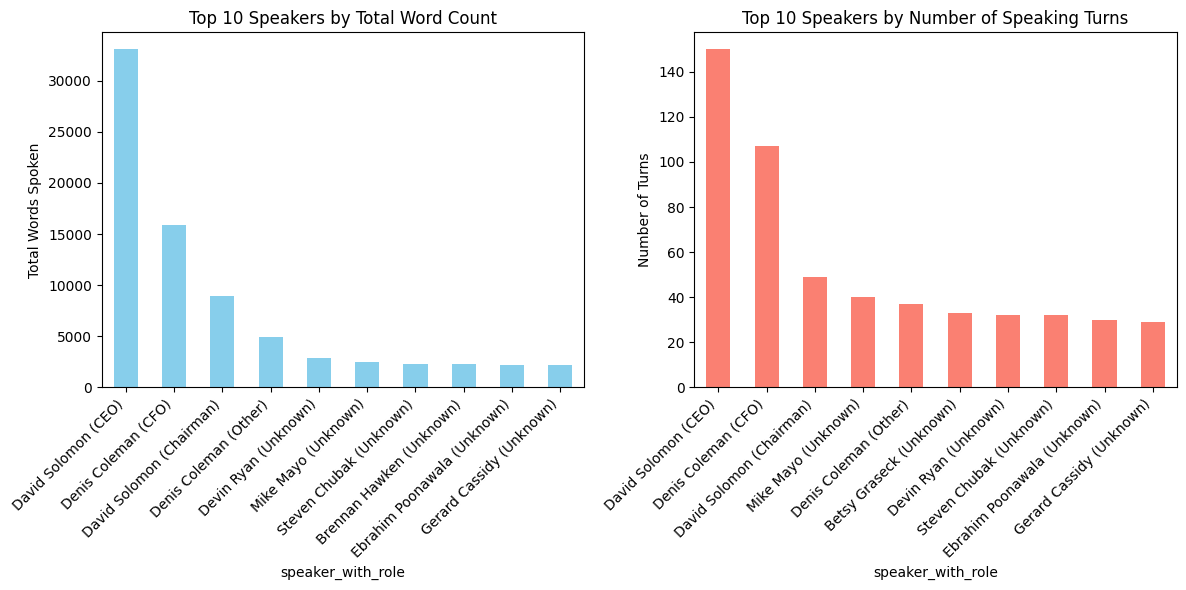

<ipython-input-3-5657e8afe840>:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_count_by_role.values, y=word_count_by_role.index, palette="Blues_d")


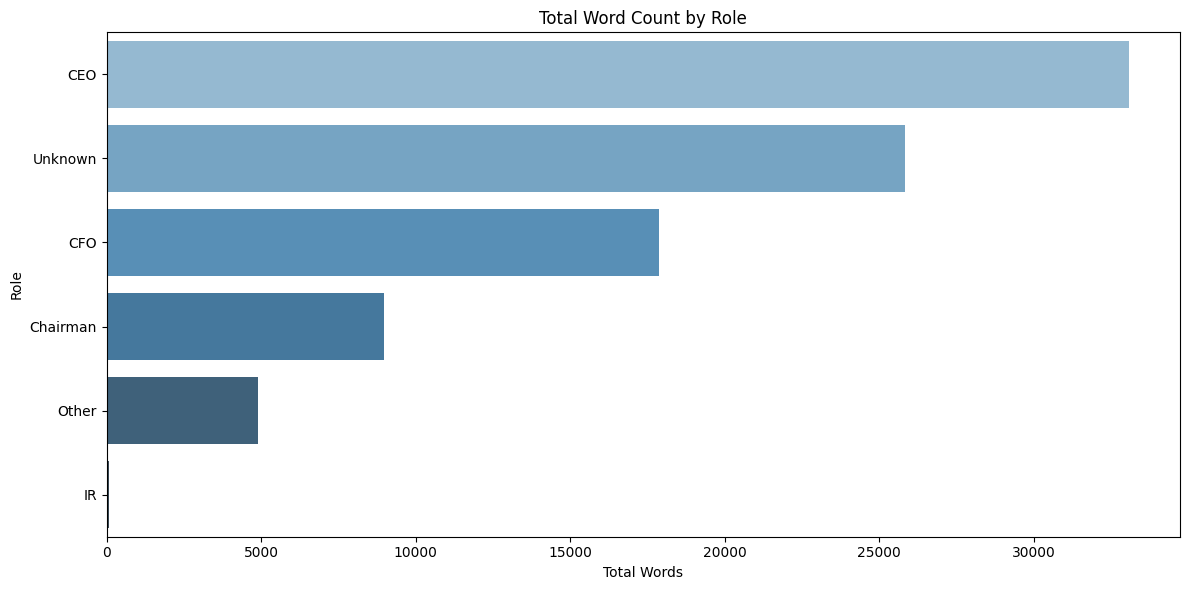

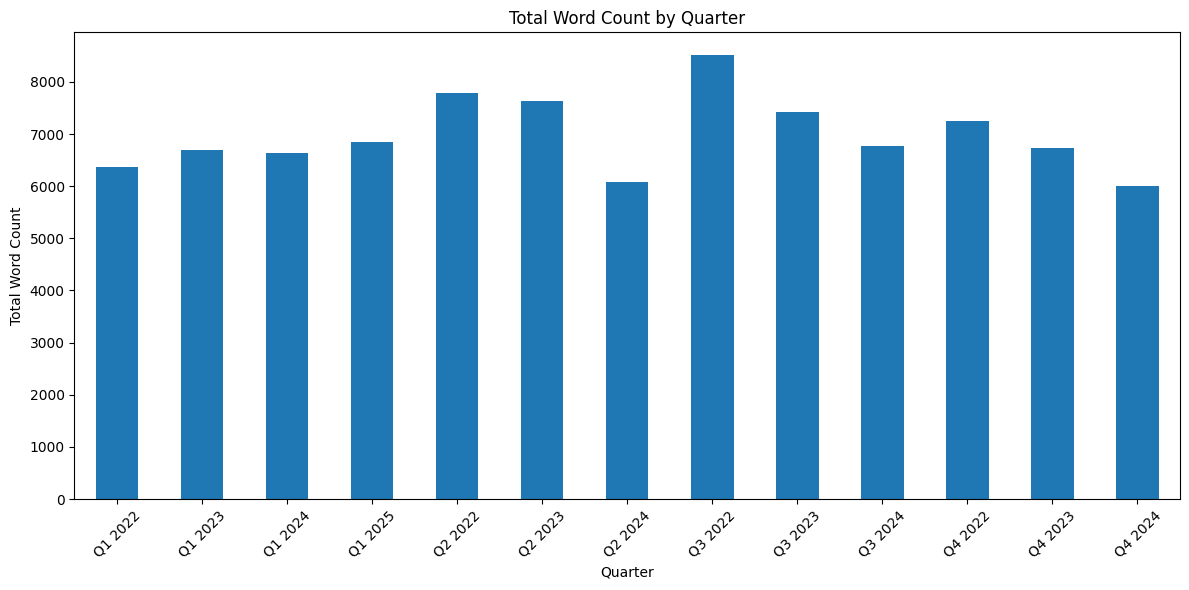

<ipython-input-3-5657e8afe840>:111: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top10 = turns.groupby('quarter_year').apply(lambda x: x.nlargest(10, 'turns')).reset_index(drop=True)


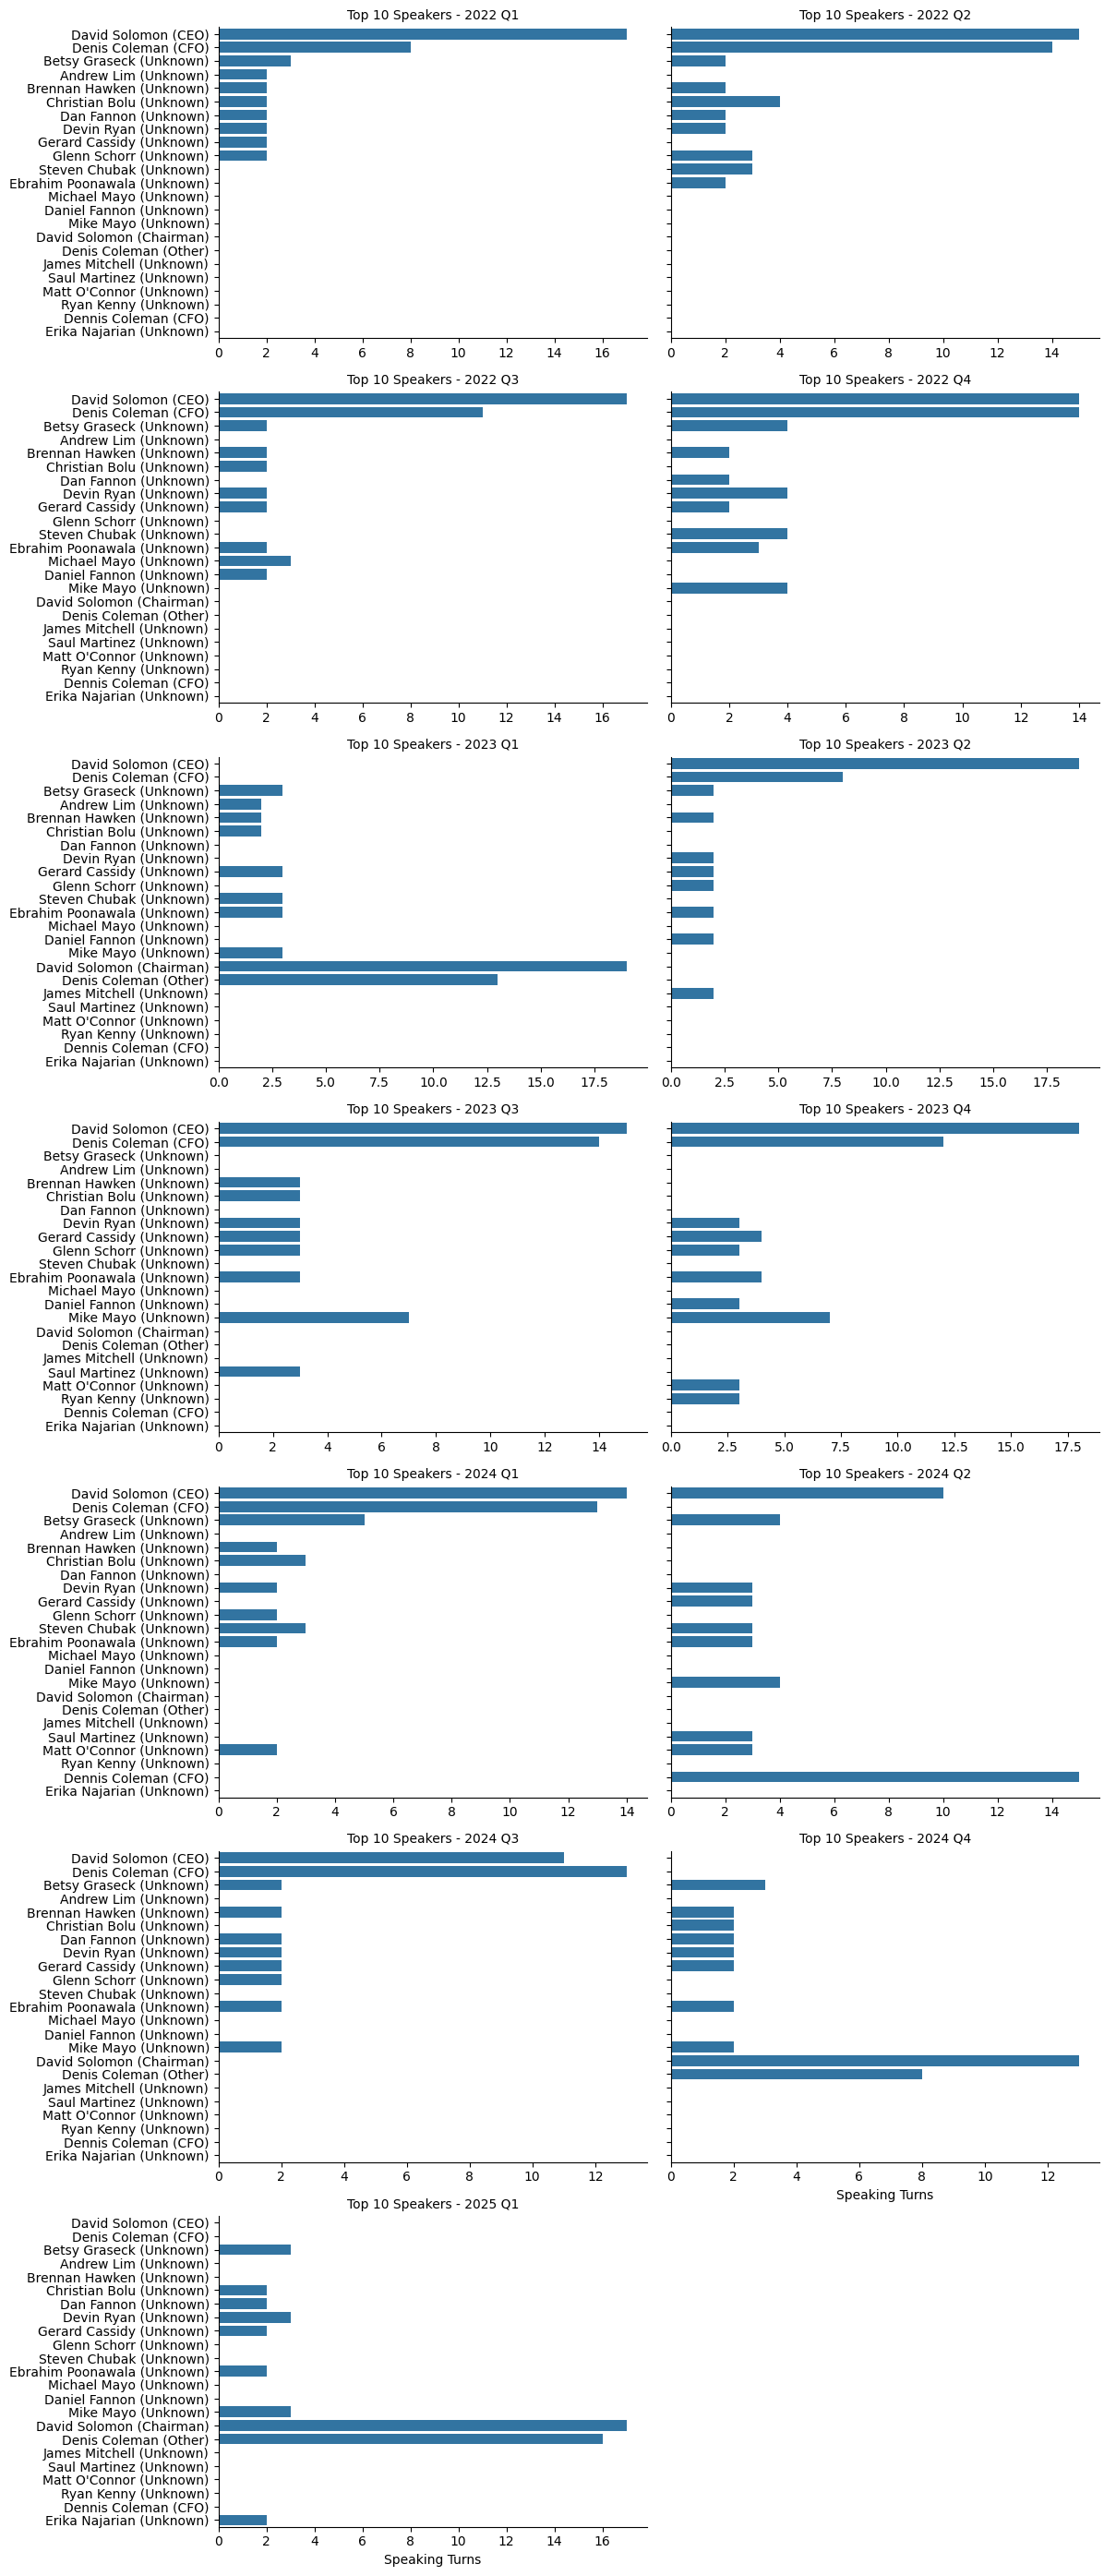

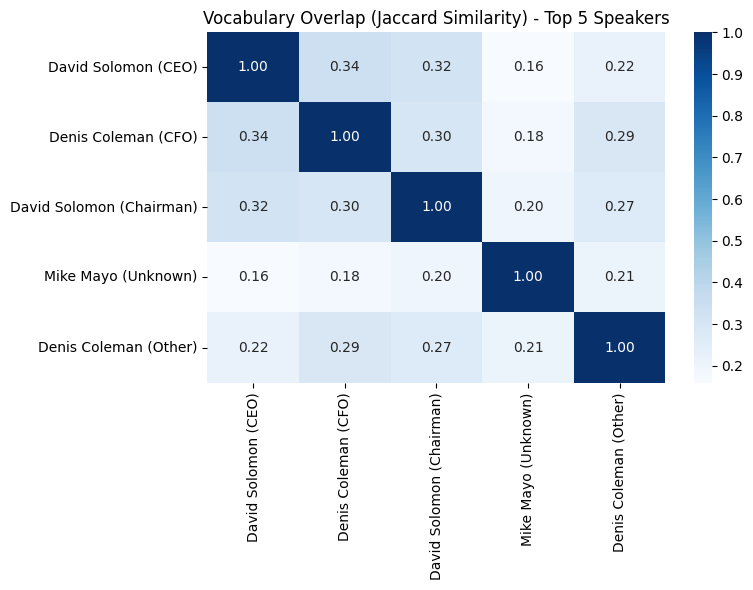

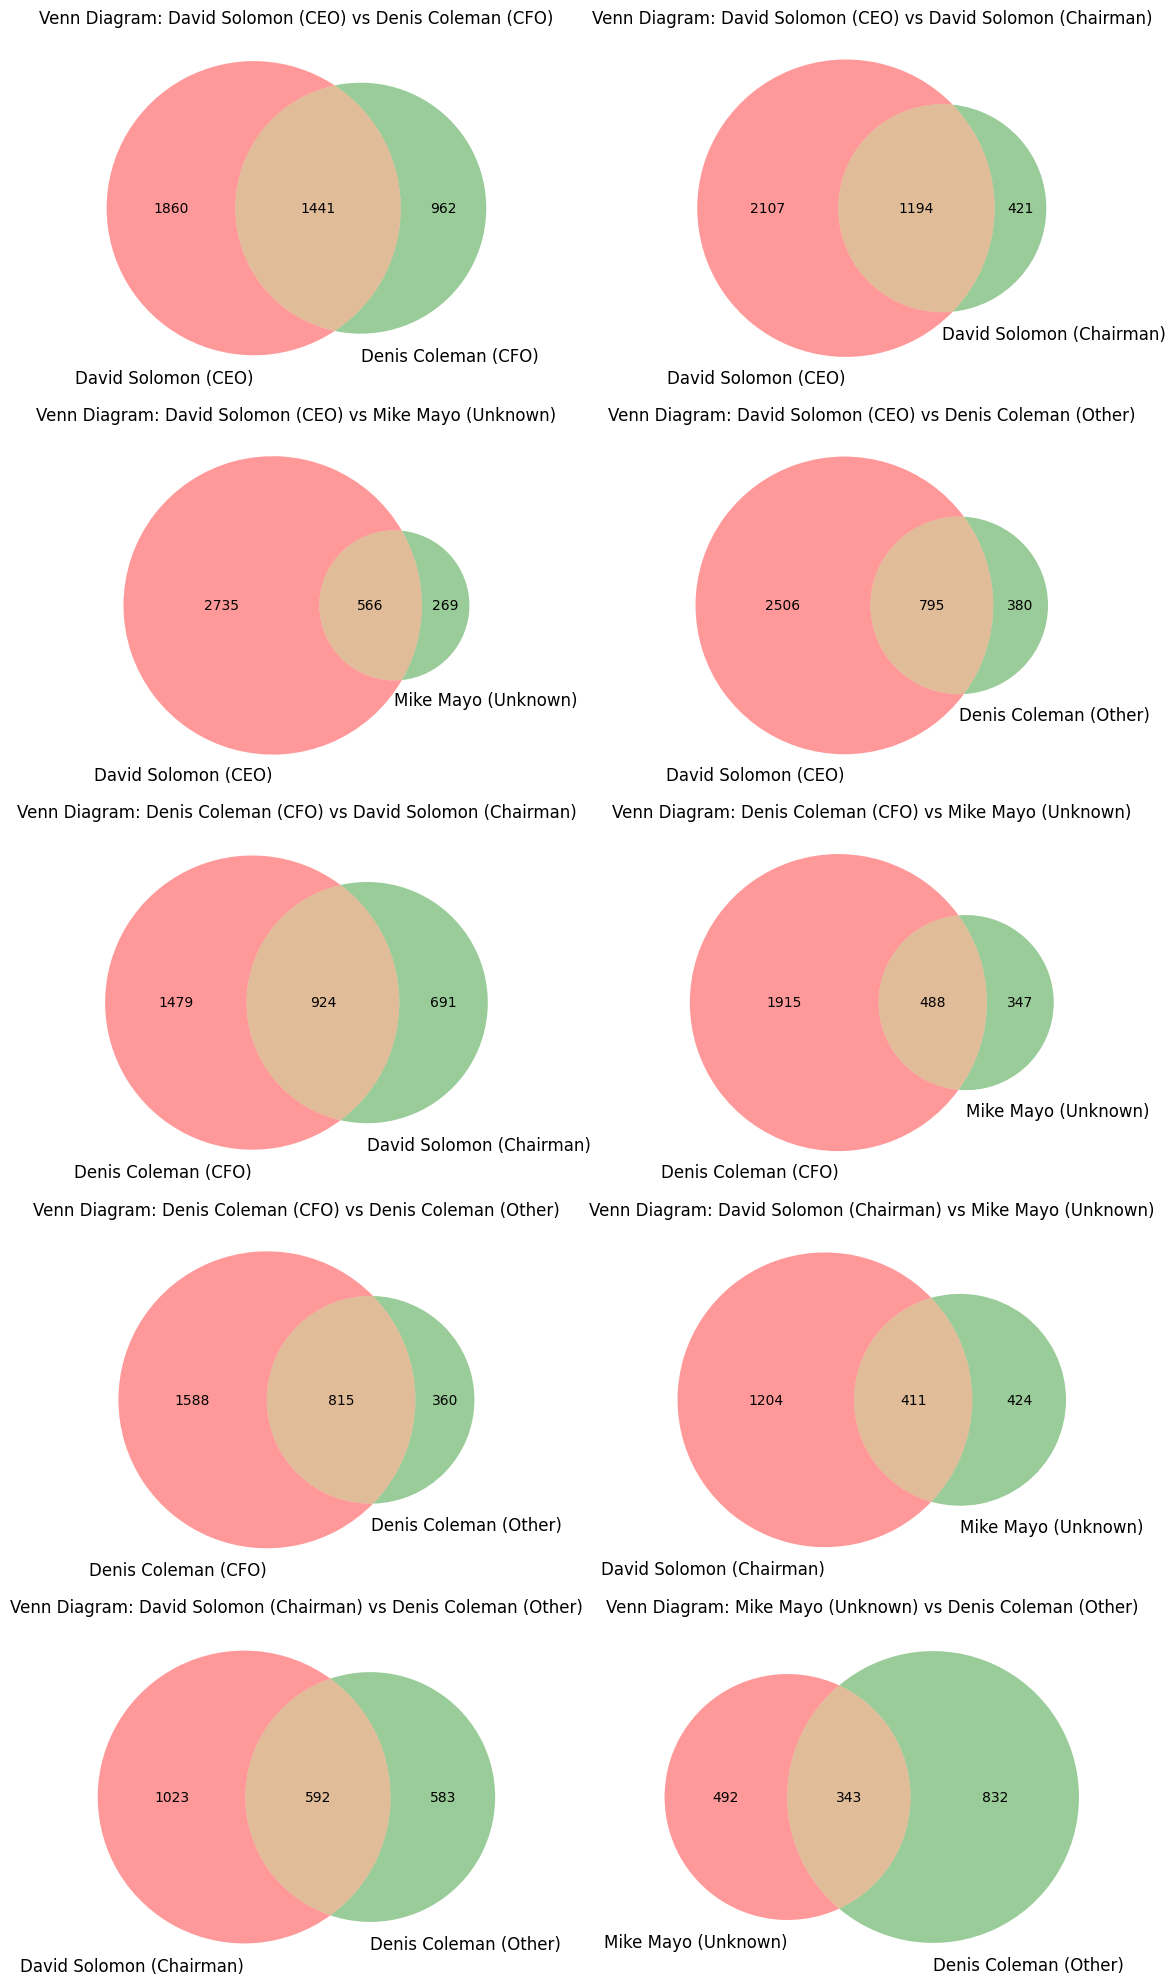

In [ ]:
# Run this section to load and visualize everything
csv_path = "/content/qna_df (1).csv"

df = load_data(csv_path)
summarize_missing(df)
df_clean = prepare_data(df)

plot_top_speakers(df_clean)
plot_word_count_by_role(df_clean)
plot_word_count_by_quarter(df_clean)
plot_top_speakers_per_quarter(df_clean)
plot_vocab_overlap_heatmap(df_clean)
plot_venn_diagrams(df_clean)


In [ ]:
# Apply the filter to get financial words per row
financial_keywords = {
    "revenue", "loan", "loans", "capital", "margin", "nii", "nii", "expense", "expenses",
    "cost", "costs", "asset", "assets", "liability", "liabilities", "net", "interest",
    "income", "debt", "credit", "equity", "dividend", "tax", "profit", "loss", "liquidity",
    "return", "yield", "growth", "inflation", "rates", "spread", "valuation", "earnings",
    "fee", "fees", "cash", "guidance", "forecast", "portfolio", "deposit", "deposits",
    "risk", "hedge", "investment", "investments", "buyback", "underwriting"
}

def filter_financial_terms(word_list):
    return [w for w in word_list if w in financial_keywords]

df_clean['financial_words'] = df_clean['cleaned_words'].apply(filter_financial_terms)

display(df_clean.head())

,question_order,question_answer_group_id,speaker,role,company,content_type,content,quarter,year,cleaned_words,word_count,role_simple,speaker_with_role,quarter_str,quarter_year,financial_words
0,0,0,Glenn Schorr,NaN,Evercore,question,"so, trading question, i mean, markets busines...",3,2024,"[so, trading, question, i, mean, markets, busi...",96,Unknown,Glenn Schorr (Unknown),Q3 2024,2024 Q3,[]
1,1,0,David Solomon,"Chairman, Chief Executive Ofﬁcer",Goldman Sachs,answer,"i appreciate the question, glenn, and i mean,...",3,2024,"[i, appreciate, the, question, glenn, and, i, ...",442,CEO,David Solomon (CEO),Q3 2024,2024 Q3,"[growth, growth, capital, return]"
2,2,0,Glenn Schorr,NaN,Evercore,question,i appreciate that. this one will be a short f...,3,2024,"[i, appreciate, that, this, one, will, be, a, ...",90,Unknown,Glenn Schorr (Unknown),Q3 2024,2024 Q3,"[investments, capital, revenue]"
3,3,0,Denis Coleman,Chief Financial Ofﬁcer,Goldman Sachs,answer,"glenn, its denis. i guess what i would sugges...",3,2024,"[glenn, its, denis, i, guess, what, i, would, ...",145,CFO,Denis Coleman (CFO),Q3 2024,2024 Q3,"[investments, revenue, revenue, growth, guidan..."
4,0,1,Ebrahim Poonawala,NaN,Bank of America,question,i just had a follow-up ﬁrst on trading and ma...,3,2024,"[i, just, had, a, follow, up, ﬁrst, on, tradin...",93,Unknown,Ebrahim Poonawala (Unknown),Q3 2024,2024 Q3,"[income, equity]"


<ipython-input-6-601c33aae33d>:2: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  role_word_lists = df_clean.groupby('role_simple')['financial_words'].apply(sum)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette`

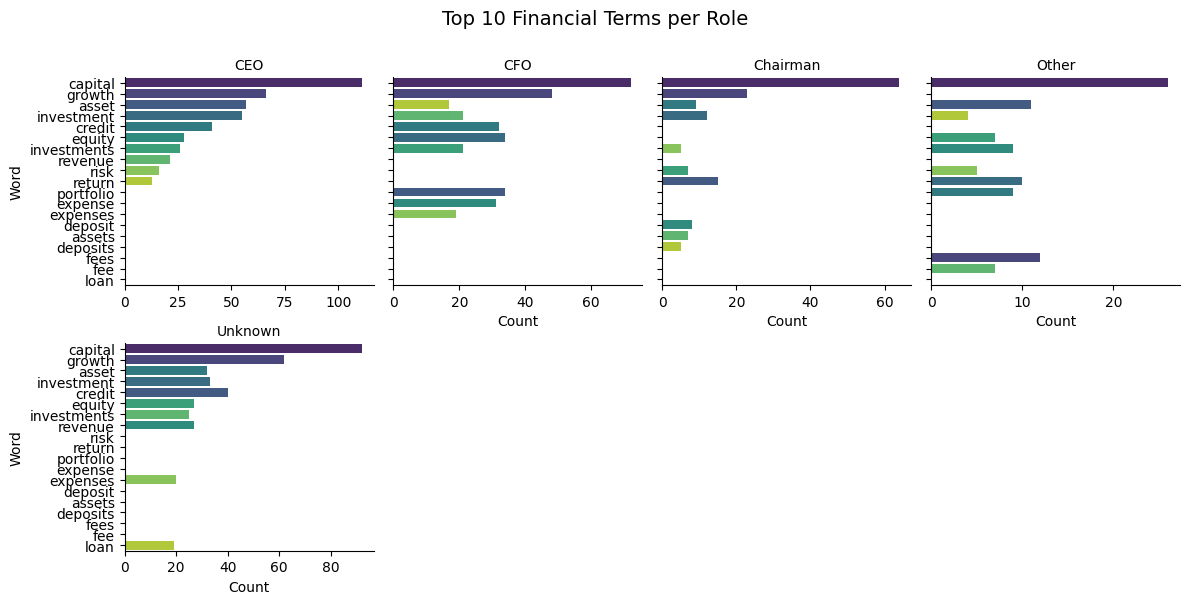

In [ ]:
# Group words by role
role_word_lists = df_clean.groupby('role_simple')['financial_words'].apply(sum)

# Top 10 words per role
top_words_by_role = {
    role: Counter(words).most_common(10)
    for role, words in role_word_lists.items()
}

# Prepare for plotting
plot_data = []
for role, words in top_words_by_role.items():
    for word, count in words:
        plot_data.append({'Role': role, 'Word': word, 'Count': count})
plot_df = pd.DataFrame(plot_data)

# Visualize
g = sns.FacetGrid(plot_df, col="Role", col_wrap=4, height=3, sharex=False)
g.map_dataframe(sns.barplot, x="Count", y="Word", palette="viridis")
g.set_titles("{col_name}")
g.set_axis_labels("Count", "Word")
g.fig.suptitle("Top 10 Financial Terms per Role", fontsize=14, y=1)
plt.tight_layout()
plt.show()

In [ ]:
# Tokenize, lowercase and extract financial words per row
import re

def extract_financial_terms(text):
    if pd.isnull(text): return []
    words = re.findall(r'\b\w+\b', text.lower())
    return [w for w in words if w in financial_keywords]

df_clean['financial_terms'] = df_clean['content'].apply(extract_financial_terms)

# Expand terms for each quarter
from collections import Counter

# Group by quarter and aggregate terms
top_financial_words_per_quarter = {}
for label, group in df_clean.groupby('quarter_year'):
    all_terms = [term for sublist in group['financial_terms'] for term in sublist]
    counter = Counter(all_terms).most_common(10)
    top_financial_words_per_quarter[label] = counter

# Display sample
import pprint
pprint.pprint(dict(list(top_financial_words_per_quarter.items())[:4]))

{'2022 Q1': [('capital', 23),
             ('growth', 20),
             ('equity', 9),
             ('investments', 8),
             ('investment', 8),
             ('loan', 8),
             ('credit', 8),
             ('revenue', 6),
             ('portfolio', 5),
             ('risk', 5)],
 '2022 Q2': [('capital', 31),
             ('equity', 12),
             ('growth', 12),
             ('portfolio', 11),
             ('expense', 10),
             ('credit', 9),
             ('investments', 8),
             ('revenue', 8),
             ('expenses', 7),
             ('assets', 5)],
 '2022 Q3': [('growth', 23),
             ('capital', 14),
             ('deposits', 14),
             ('equity', 9),
             ('asset', 9),
             ('investment', 7),
             ('deposit', 7),
             ('risk', 6),
             ('expenses', 6),
             ('expense', 6)],
 '2022 Q4': [('asset', 26),
             ('capital', 19),
             ('growth', 18),
             ('expense', 13),

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be remo

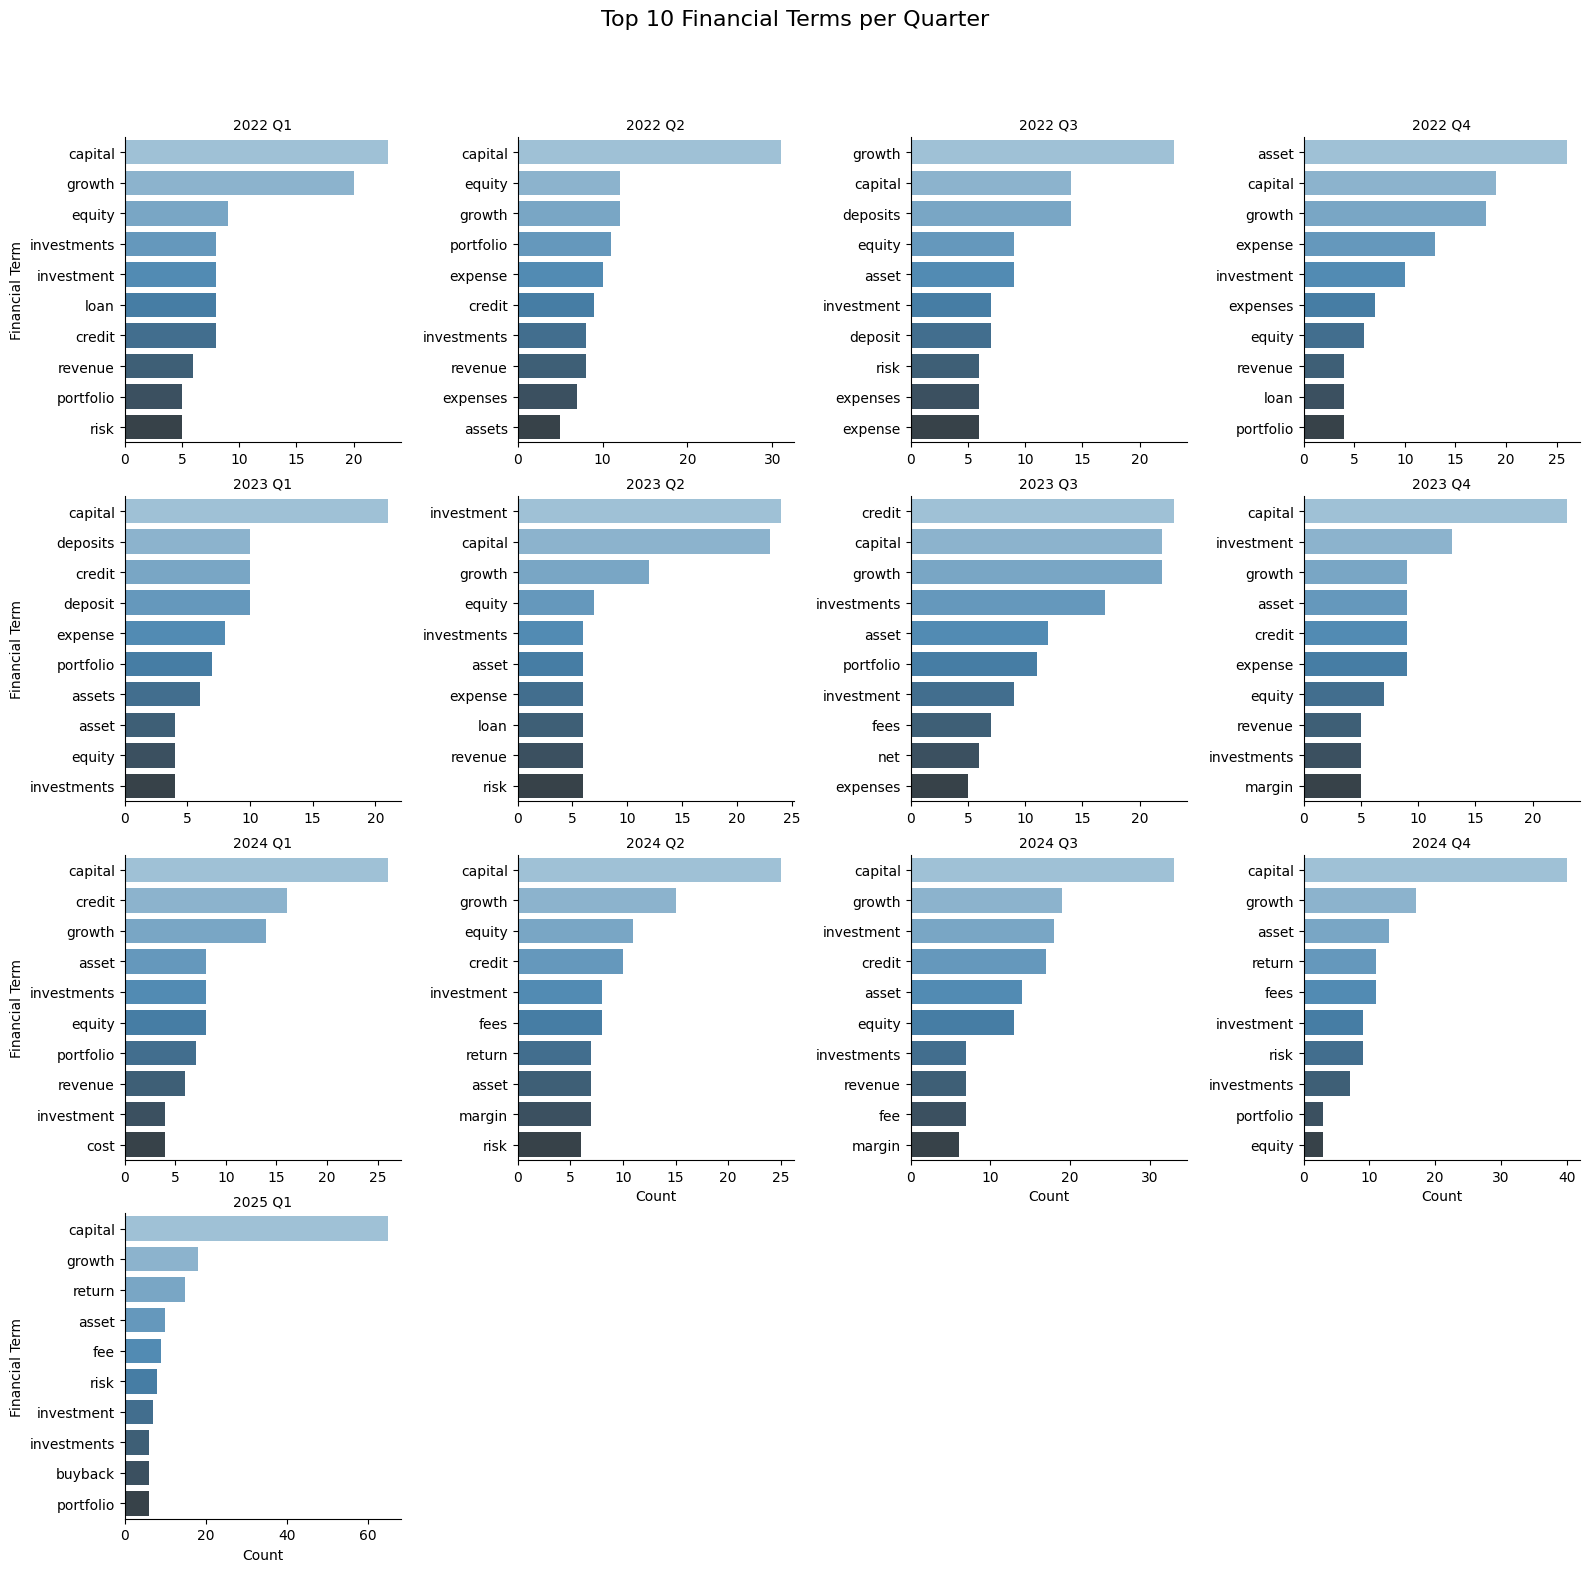

In [ ]:
# Convert the Counter dictionary into a flat DataFrame
records = []
for quarter, word_counts in top_financial_words_per_quarter.items():
    for word, count in word_counts:
        records.append({"Quarter": quarter, "Word": word, "Count": count})

top_terms_df = pd.DataFrame(records)

# Sort quarters chronologically for consistent plotting
# Add a check for the number of elements after splitting and handle potential non-integer years
def sort_key(x):
    parts = x.split('-')
    if len(parts) == 2:
        try:
            year = int(parts[1])
            quarter = parts[0]
            return (year, quarter)
        except ValueError:
            # Handle cases where the second part is not an integer
            return (0, x) # Place these at the beginning or end as needed
    else:
        # Handle cases with unexpected formats
        return (0, x) # Place these at the beginning or end as needed

quarter_order = sorted(top_terms_df['Quarter'].unique(), key=sort_key)
top_terms_df['Quarter'] = pd.Categorical(top_terms_df['Quarter'], categories=quarter_order, ordered=True)

# Plot with seaborn: Grid of barplots
g = sns.FacetGrid(top_terms_df, col="Quarter", col_wrap=4, height=4, sharex=False, sharey=False)
g.map_dataframe(sns.barplot, x="Count", y="Word", palette="Blues_d")
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Count", "Financial Term")
g.tight_layout()
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Top 10 Financial Terms per Quarter", fontsize=16)
plt.show()

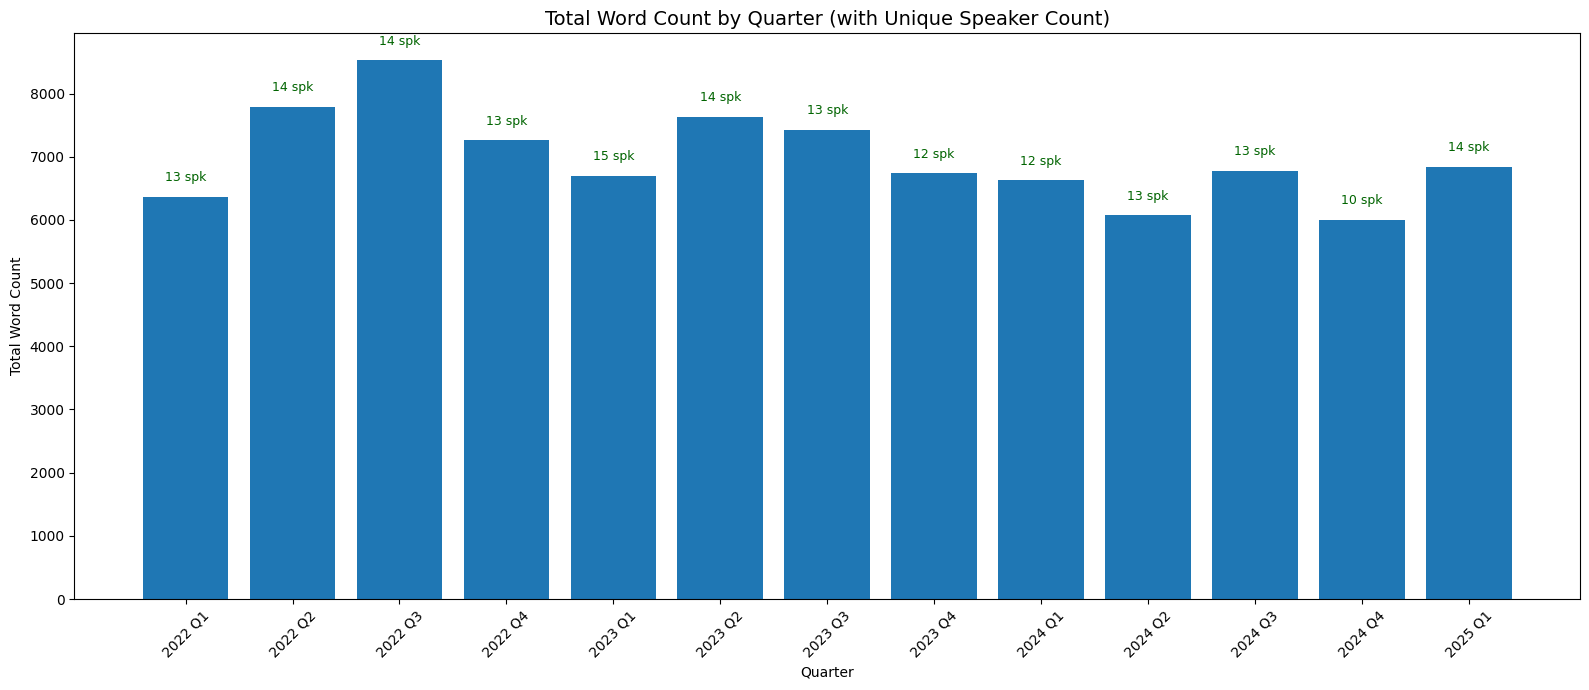

In [ ]:
# Compute total word count and unique speaker count per quarter
agg_df = df_clean.groupby('quarter_year').agg(
    total_words=('content', lambda x: x.str.split().str.len().sum()),
    unique_speakers=('speaker', pd.Series.nunique)
).reset_index()

# Sort quarter labels chronologically
agg_df = agg_df.sort_values(by='quarter_year', key=lambda col: col.map(
    lambda x: (int(x.split()[0]) if len(x.split()) > 1 else 0, x.split()[1] if len(x.split()) > 1 else x)))

# Plot the total word count
plt.figure(figsize=(16, 7))
bars = plt.bar(agg_df['quarter_year'], agg_df['total_words'])

# Add speaker count labels above each bar
for bar, count in zip(bars, agg_df['unique_speakers']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 200, f"{count} spk",
             ha='center', va='bottom', fontsize=9, color='darkgreen')

# Titles and labels
plt.title("Total Word Count by Quarter (with Unique Speaker Count)", fontsize=14)
plt.xlabel("Quarter")
plt.ylabel("Total Word Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

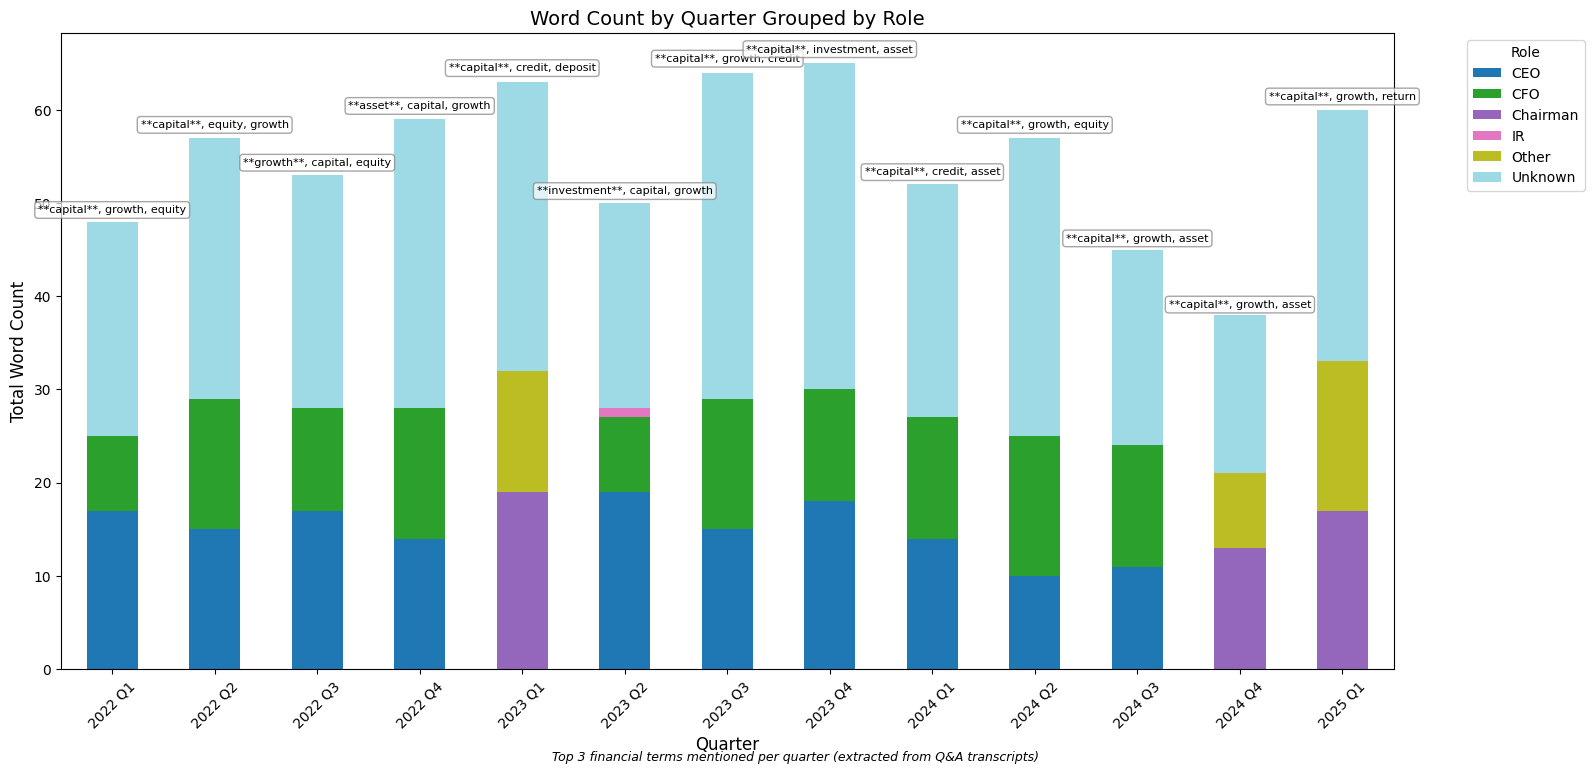

In [ ]:
# --- Define financial keywords ---
financial_keywords = {
    "revenue", "loan", "loans", "capital", "margin", "nii", "expense", "expenses",
    "cost", "costs", "asset", "assets", "liability", "liabilities", "net", "interest",
    "income", "debt", "credit", "equity", "dividend", "tax", "profit", "loss", "liquidity",
    "return", "yield", "growth", "inflation", "rates", "spread", "valuation", "earnings",
    "fee", "fees", "cash", "guidance", "forecast", "portfolio", "deposit", "deposits",
    "risk", "hedge", "investment", "investments", "buyback", "underwriting"
}

# --- Step 1: Build dict: quarter -> top 3 financial words ---
top_words_per_quarter = {}

# Ensure quarter_year is sorted chronologically (e.g., 2022 Q1 to 2025 Q1)
def sort_key(q):
    parts = q.split() # Split by space
    if len(parts) == 2:
        try:
            year = int(parts[0]) # Year is the first part
            quarter = parts[1] # Quarter is the second part
            return (year, quarter)
        except ValueError:
            # Handle cases where the parts are not as expected
            return (0, q) # Place these at the beginning or end as needed
    else:
        # Handle cases with unexpected formats
        return (0, q) # Place these at the beginning or end as needed

# Group by quarter and aggregate content
for quarter, group in df_clean.groupby('quarter_year'):
    words = " ".join(group["content"].dropna().astype(str)).lower().split()
    filtered_words = [w for w in words if w in financial_keywords]
    most_common = Counter(filtered_words).most_common(3)
    if most_common:
        # Bold the most frequent word
        formatted = [f"**{most_common[0][0]}**"] + [w for w, _ in most_common[1:]]
        top_words_per_quarter[quarter] = ", ".join(formatted)
    else:
        top_words_per_quarter[quarter] = ""

# --- Create the pivot table for plotting ---
# Assuming 'role_simple' and 'quarter_year' are in df_clean
pivot = df_clean.groupby(['quarter_year', 'role_simple']).size().unstack(fill_value=0)

# Sort pivot table columns (roles) alphabetically and rows (quarters) chronologically
pivot = pivot.sort_index(axis=1).sort_index(key=lambda col: col.map(sort_key))


# --- Step 2: Annotate the stacked barplot ---
ax = pivot.plot(kind='bar', stacked=True, figsize=(16, 8), colormap='tab20')

plt.title("Word Count by Quarter Grouped by Role", fontsize=14)
plt.xlabel("Quarter", fontsize=12)
plt.ylabel("Total Word Count", fontsize=12)
plt.xticks(rotation=45)

# Annotate with top words dynamically above bars
for i, quarter in enumerate(pivot.index):
    total_height = pivot.loc[quarter].sum()
    offset = total_height * 0.015  # ~1.5% of total bar height
    words = top_words_per_quarter.get(quarter, "")
    ax.text(i, total_height + offset, words, ha='center', va='bottom', fontsize=8,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray', boxstyle='round,pad=0.3'))

# Improve layout and spacing
plt.legend(title='Role', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.subplots_adjust(top=0.92)  # Give space for text boxes above bars

# Caption (optional)
plt.figtext(0.5, 0.01, "Top 3 financial terms mentioned per quarter (extracted from Q&A transcripts)",
            wrap=True, horizontalalignment='center', fontsize=9, style='italic')

plt.show()

# Key Observations:

Role-wise Engagement:
CEO and CFO consistently dominate contributions, especially until 2024 Q2.

IR (Investor Relations) and Chairman roles are sparsely active, except in 2023 Q1 and 2025 Q1, where Chairman’s contribution spikes.

Unknown category remains substantial, suggesting either unidentified speakers or transcript segments not tagged to specific roles.

 Keyword Themes:
"Capital" is the most persistent keyword — present in nearly every quarter, reflecting sustained focus on capital ratios, buffers, and optimization.

"Growth" and "asset" consistently appear alongside "capital" in many quarters, indicating strategic positioning in terms of expansion and asset mix.

Unique keywords per quarter (e.g., "credit", "return", "investment") show contextual or event-driven focus, especially:

2023 Q1: Credit and deposit, possibly referencing banking system stress or liquidity themes.

2023 Q2 & 2023 Q4: Investment and asset discussions, potentially linked to portfolio shifts or macro allocation.

# Keyword Themes:

"Capital" is the most persistent keyword — present in nearly every quarter, reflecting sustained focus on capital ratios, buffers, and optimization.

"Growth" and "asset" consistently appear alongside "capital" in many quarters, indicating strategic positioning in terms of expansion and asset mix.

Unique keywords per quarter (e.g., "credit", "return", "investment") show contextual or event-driven focus, especially:

2023 Q1: Credit and deposit, possibly referencing banking system stress or liquidity themes.

2023 Q2 & 2023 Q4: Investment and asset discussions, potentially linked to portfolio shifts or macro allocation.

# Quarter Highlights:

2023 Q1: High Chairman involvement and unique keyword set — implies a response to a key event or strategic shift.

2024 Q2 to Q4: Decline in CEO/CFO word count and more presence of ‘Other’ and ‘Unknown’ — could reflect less executive commentary or increased analyst/IR engagement.

2025 Q1: High Chairman participation again, reinforcing board-level emphasis in that quarter.

# Interpretation:

Goldman Sachs emphasizes capital as a central theme, much like JP Morgan — but with more varied supporting themes like asset, equity, return.

The CEO and CFO drive the bulk of discourse until mid-2024, after which there's a broader spread across roles, especially in Chairman and Other.

Spike in IR and Chairman roles in specific quarters may correspond to periods of market scrutiny, earnings stress, or structural updates.

# Summary:

Goldman Sachs’ transcript analysis shows a boardroom-led, capital-centered narrative punctuated by strategic terms like growth, asset, and credit. The shift in speaker roles and terms in 2023–2025 hints at internal realignment or adaptive strategy in response to macro or regulatory dynamics.



In [ ]:
print(df.columns)


Index(['question_order', 'question_answer_group_id', 'speaker', 'role',
       'company', 'content_type', 'content', 'quarter', 'year'],
      dtype='object')


In [ ]:
from itertools import combinations
import re
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

def plot_venn_diagrams_financial_only(df):
    financial_keywords = {
        "revenue", "loan", "loans", "capital", "margin", "nii", "expense", "expenses",
        "cost", "costs", "asset", "assets", "liability", "liabilities", "net", "interest",
        "income", "debt", "credit", "equity", "dividend", "tax", "profit", "loss", "liquidity",
        "return", "yield", "growth", "inflation", "rates", "spread", "valuation", "earnings",
        "fee", "fees", "cash", "guidance", "forecast", "portfolio", "deposit", "deposits",
        "risk", "hedge", "investment", "investments", "buyback", "underwriting"
    }

    # Top 5 speakers by number of speaking turns
    top5_speakers = df['speaker'].value_counts().head(5).index.tolist()

    # Filter each speaker's vocabulary to financial keywords only
    speaker_vocab = {
        speaker: set(re.findall(r'\b\w+\b', ' '.join(
            df[df['speaker'] == speaker]['content'].tolist()
        ).lower())) & financial_keywords
        for speaker in top5_speakers
    }

    # Optional: Print to verify vocab
    for speaker, words in speaker_vocab.items():
        print(f"{speaker}: {sorted(words)}")

    # Generate pairwise venn diagrams
    pairs = list(combinations(top5_speakers, 2))
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 20))

    for ax, (s1, s2) in zip(axes.flatten(), pairs):
        set1, set2 = speaker_vocab[s1], speaker_vocab[s2]
        venn2([set1, set2], set_labels=(s1, s2), ax=ax)
        ax.set_title(f"Venn Diagram (Financial Words): {s1} vs {s2}")

    plt.tight_layout()
    plt.show()


Jeremy Barnum: ['asset', 'assets', 'buyback', 'capital', 'cash', 'cost', 'costs', 'credit', 'debt', 'deposit', 'deposits', 'dividend', 'earnings', 'equity', 'expense', 'expenses', 'fee', 'fees', 'forecast', 'growth', 'guidance', 'income', 'inflation', 'interest', 'investment', 'investments', 'liabilities', 'liability', 'liquidity', 'loan', 'loans', 'loss', 'margin', 'net', 'nii', 'portfolio', 'rates', 'return', 'revenue', 'risk', 'spread', 'tax', 'underwriting', 'valuation', 'yield']
Jamie Dimon: ['asset', 'assets', 'buyback', 'capital', 'cash', 'cost', 'credit', 'debt', 'deposit', 'deposits', 'dividend', 'earnings', 'equity', 'expense', 'expenses', 'forecast', 'growth', 'guidance', 'hedge', 'income', 'inflation', 'interest', 'investment', 'investments', 'liquidity', 'loan', 'loans', 'loss', 'net', 'nii', 'portfolio', 'rates', 'return', 'revenue', 'risk', 'spread', 'underwriting', 'valuation', 'yield']
Betsy L. Graseck: ['asset', 'assets', 'buyback', 'capital', 'cost', 'credit', 'depos

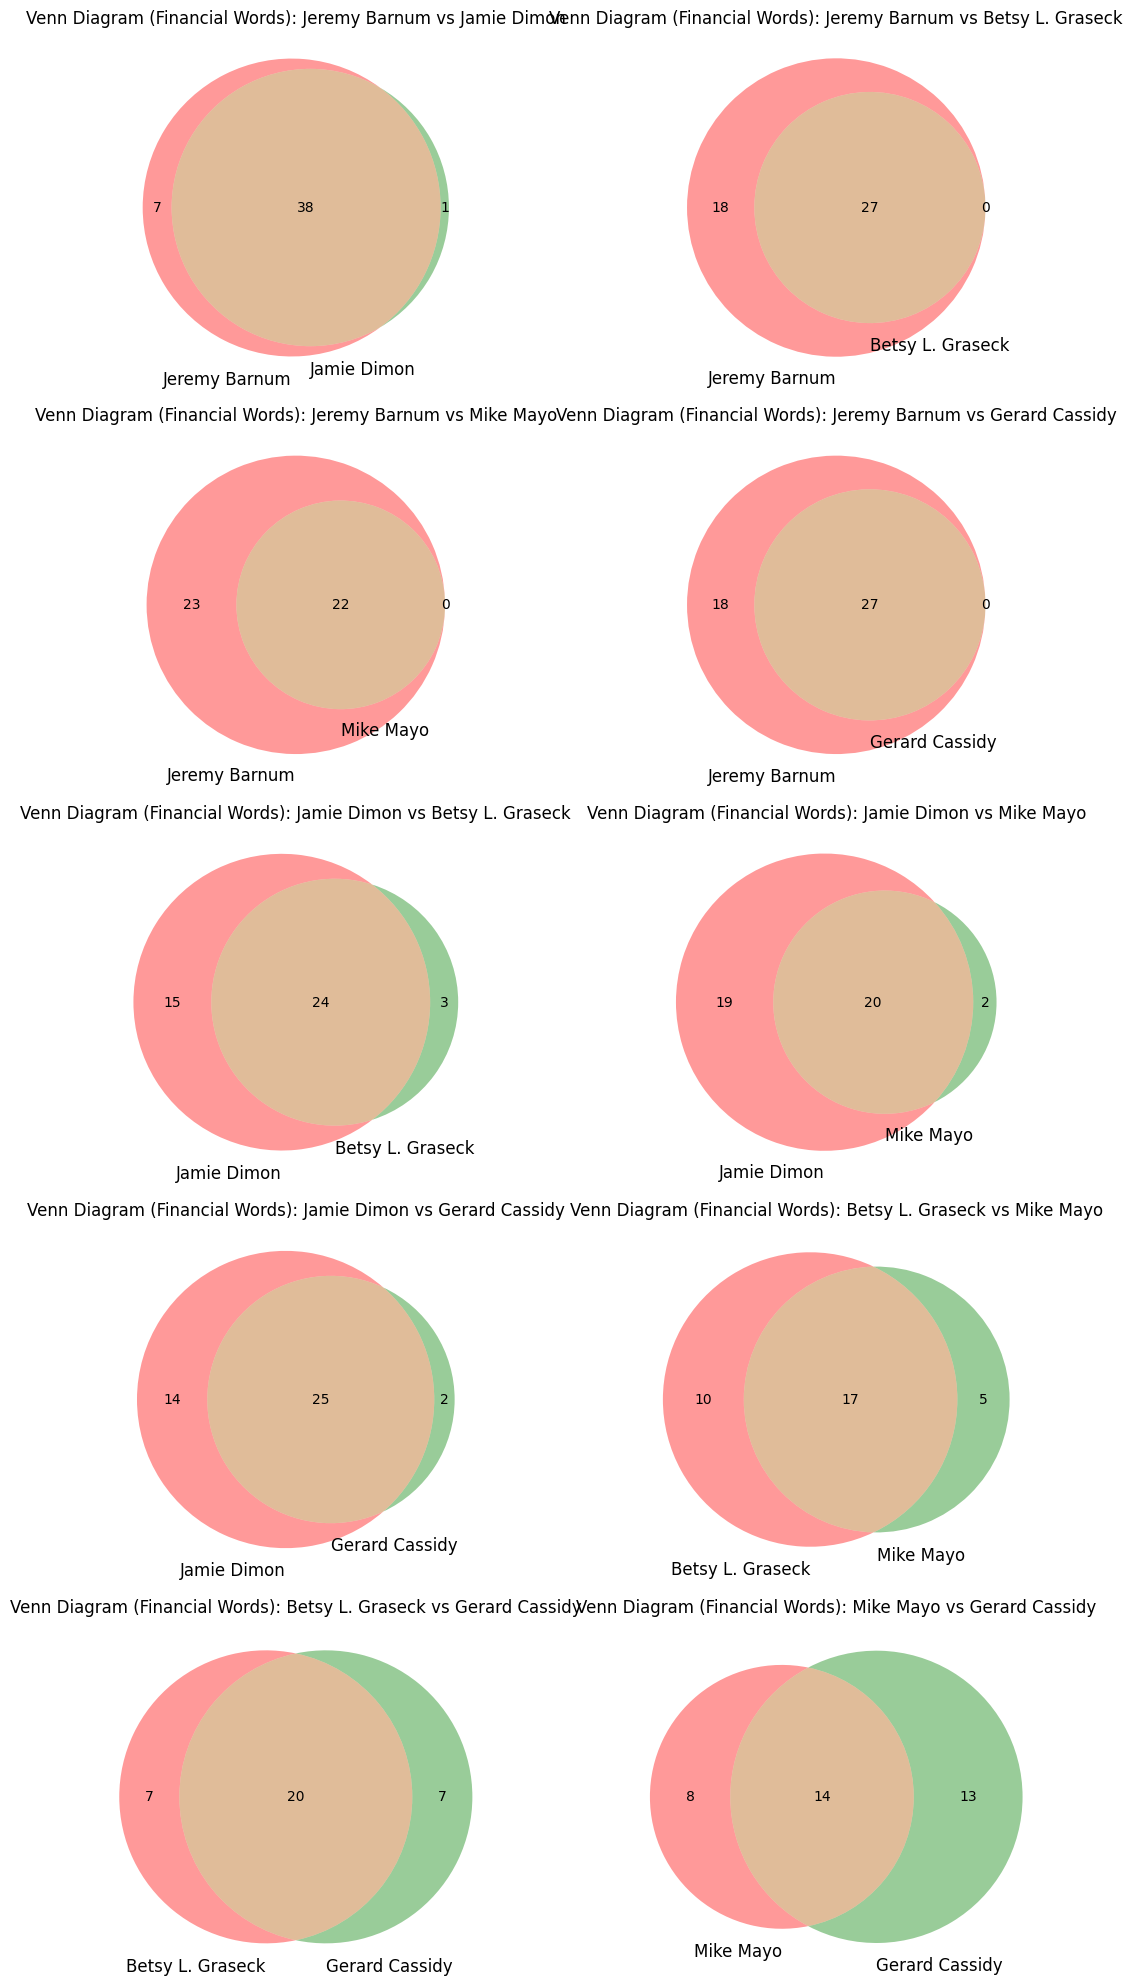

In [ ]:
plot_venn_diagrams_financial_only(df)


In [ ]:
import pandas as pd
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# Use the existing df_clean DataFrame which already has 'quarter_year' and 'clean_text'

# Ensure year_quarter is in string format (already should be from df_clean creation)
df_clean['year_quarter'] = df_clean['quarter_year'].astype(str)

# Normalize text (already done in df_clean creation, but ensure lowercase)
df_clean['clean_text'] = df_clean['content'].fillna('').str.lower()



In [ ]:
financial_keywords = {
    "revenue", "loan", "loans", "capital", "margin", "nii", "expense", "expenses",
    "cost", "costs", "asset", "assets", "liability", "liabilities", "net", "interest",
    "income", "debt", "credit", "equity", "dividend", "tax", "profit", "loss", "liquidity",
    "return", "yield", "growth", "inflation", "rates", "spread", "valuation", "earnings",
    "fee", "fees", "cash", "guidance", "forecast", "portfolio", "deposit", "deposits",
    "risk", "hedge", "investment", "investments", "buyback", "underwriting"
}

# Count keywords per quarter
trend_counts = defaultdict(lambda: Counter())

for _, row in df_clean.iterrows():
    quarter = row['year_quarter']
    words = row['clean_text'].split()
    for word in words:
        if word in financial_keywords:
            trend_counts[quarter][word] += 1

# Convert to DataFrame
trend_df = pd.DataFrame(trend_counts).fillna(0).astype(int).T.sort_index()
display(trend_df.head())

,growth,capital,return,revenue,guidance,portfolio,income,equity,asset,credit,...,costs,cost,liability,nii,interest,hedge,buyback,cash,forecast,spread
2022 Q1,17,20,2,6,0,5,0,9,5,8,...,0,3,1,3,2,0,0,0,0,0
2022 Q2,11,27,2,8,0,8,0,12,1,9,...,0,1,0,0,1,0,0,0,1,0
2022 Q3,18,11,2,1,0,0,1,9,9,3,...,2,4,0,0,0,0,0,1,0,1
2022 Q4,13,18,1,3,0,3,1,6,26,1,...,0,1,0,0,2,0,2,0,0,0
2023 Q1,3,20,3,1,0,4,2,4,4,10,...,0,1,0,1,1,4,2,1,0,0


In [ ]:
import plotly.graph_objects as go

# Calculate the total frequency of each word across all quarters
word_totals = trend_df.sum().sort_values(ascending=False)

# Get the top 10 most frequent words
top10_words = word_totals.head(10).index.tolist()

# Create an interactive figure
fig = go.Figure()

# Add a trace for each of the top 10 words
for word in top10_words:
    fig.add_trace(go.Scatter(
        x=trend_df.index.astype(str),
        y=trend_df[word],
        mode='lines+markers',
        name=word
    ))

# Customize layout
fig.update_layout(
    title="Interactive Trend of Top 10 Financial Keywords per Quarter",
    xaxis_title="Quarter",
    yaxis_title="Frequency",
    hovermode="x unified",
    legend_title="Keyword",
    height=600,
    width=1200
)

fig.show()

# Key Trends by Keyword:

- Capital:

Most frequently mentioned keyword overall.

Strong upward trend, especially from 2023 Q4 onward, peaking in 2025 Q1 (~47 mentions).

Indicates growing focus on capital management or requirements.

- Growth:

Variable usage but stable presence.

Peaks in 2022 Q1, 2022 Q3, and 2024 Q4.

Suggests intermittent but ongoing strategic focus.

- Asset:

Peaked in 2022 Q4 (around 26 mentions), then declined.

Likely tied to asset management or balance sheet discussions that were prominent in late 2022.

- Investment:

Significant spike in 2023 Q2, then falls off.

This could reflect an emphasis on new investment activity in that specific period.

"Equity, Credit, Investments, Return, Revenue, Risk:
All show lower frequency and more volatility.

Risk and return are used inconsistently, suggesting they're context-driven terms rather than core themes.

# Interpretation:

Capital is becoming an increasingly dominant theme — likely due to regulatory pressures, internal restructuring, or strategic shifts in capital allocation.

Other keywords like growth, investment, and asset appear to rise in importance during specific periods, hinting at quarterly priorities or changing macroeconomic conditions.

Less frequent keywords like risk or return may reflect more selective or situational mentions, rather than strategic focus.

# Strategic Implication:

Goldman Sachs' messaging has become more capital-centric over time, possibly reflecting:

Increased capital requirements or stress testing.

A strategic pivot toward core capital management.

Market response to changing rates and regulatory oversight.